## Team members

* Eric Romero kramer
* Mihir Patil
* Swaroop Bhandary K

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import glob
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import keras_metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix  
from __future__ import division
from keras import optimizers
from sklearn.svm import SVC 
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report  
from sklearn.model_selection import train_test_split  

Using TensorFlow backend.


In [3]:
fleisch = pd.read_excel('Archive_files/Archiv/Fleisch.xls').astype(float)
stoff =pd.read_excel('Archive_files/Archiv/Stoff.xls').astype(float)
leder = pd.read_excel('Archive_files/Archiv/Leder.xls').astype(float)
holz = pd.read_excel('Archive_files/Archiv/Holz.xls').astype(float)
haut = pd.read_excel('Archive_files/Archiv/Referenz-Haut_6-Klassen.xls').astype(float)
skin = pd.read_csv('Archive_files/Archiv/2016skin.csv', sep=';', decimal=',').astype(float)
skin.dropna(axis=0, inplace=True)
material = pd.read_csv('Archive_files/Archiv/2016material.csv', sep=';', decimal=',').astype(float)
material.dropna(axis=0, inplace=True)
material_fake = pd.read_csv('Archive_files/Archiv/2016material-fake.csv', sep=';', decimal=',').astype(float)
material_fake.dropna(axis=0, inplace=True)

print('================================================================')
print('Data sets shapes')
print('Fleisch ', fleisch.shape)
print('Stoff ', stoff.shape)
print('Leder ', leder.shape)
print('Haut ', haut.shape)
print('Holz ', holz.shape)
print('Skin ', skin.shape)
print('Material ', material.shape)
print('Material Fake ', material_fake.shape)

Data sets shapes
Fleisch  (121, 71)
Stoff  (121, 11)
Leder  (121, 30)
Haut  (121, 7)
Holz  (121, 63)
Skin  (1021, 1112)
Material  (1021, 336)
Material Fake  (1021, 33)


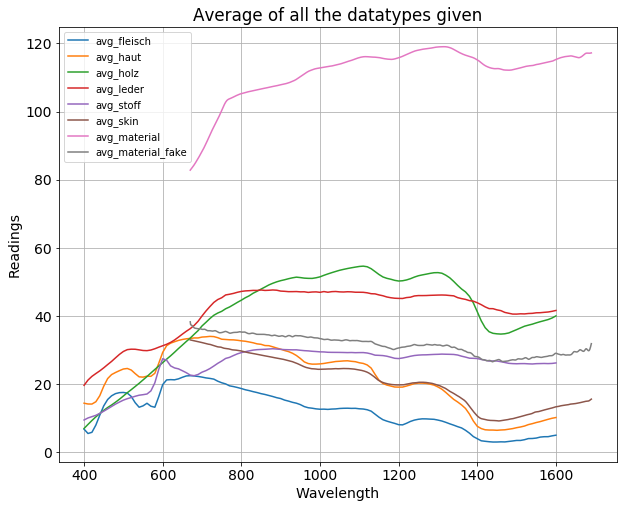

In [4]:
avg_fleisch = np.array(fleisch.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_leder = np.array(leder.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_holz = np.array(holz.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_stoff = np.array(stoff.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_haut = np.array(haut.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_skin = np.array(skin.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_material = np.array(material.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_material_fake = np.array(material_fake.iloc[:,1:].mean(axis = 1))[np.newaxis].T

wavelength = np.array(fleisch['nm'])[np.newaxis].T
wavelength_2016 = np.array(skin['nm'])[np.newaxis].T

# Plot the average values
plt.figure(figsize=[10,8])
plt.rcParams.update({'font.size': 14})

# Plot the different data 
plt.plot(wavelength,avg_fleisch,label='avg_fleisch')
plt.plot(wavelength,avg_haut,label='avg_haut')
plt.plot(wavelength,avg_holz,label='avg_holz')
plt.plot(wavelength,avg_leder,label='avg_leder')
plt.plot(wavelength,avg_stoff,label='avg_stoff')
plt.plot(wavelength_2016,avg_skin,label='avg_skin')
plt.plot(wavelength_2016,avg_material,label='avg_material')
plt.plot(wavelength_2016,avg_material_fake,label='avg_material_fake')

# Plot properties
plt.grid()
plt.title('Average of all the datatypes given')
plt.xlabel('Wavelength')
plt.ylabel('Readings')
plt.legend(loc='upper left',prop={'size': 10})

In [5]:
def dataCleanup(X, n):
    
    # Source: http://cs231n.github.io/neural-networks-2/
    X = np.array(X)
    X -= np.mean(X, axis = 0) # zero-center the data (important)
    cov = np.dot(X.T, X) / X.shape[0] # get the data covariance matrix
    U,S,V_T = np.linalg.svd(cov)
    Xrot = np.dot(X, U) # decorrelate the data
    Xrot_reduced = np.dot(X, U[:,:n]) # Xrot_reduced becomes [N x 100]
    Xwhite = Xrot_reduced / np.sqrt(S[:n] + 1e-5)
    return Xwhite



In [6]:
print('=========================================================================')
print("Performing PCA on the dataset to use the features with more relevance")
print('=========================================================================')
n = 5
print('------------- FLEISCH -------------')
fleisch_cleaned = dataCleanup(fleisch.drop(columns="nm"),n)
print('', fleisch_cleaned.shape)
print('-------------   HAUT  -------------')
haut_cleaned = dataCleanup(haut.drop(columns="nm"),n)
print('', haut_cleaned.shape)
print('-------------   SKIN  -------------')
skin_cleaned = dataCleanup(skin.drop(columns="nm"),n)
print('', skin_cleaned.shape)
print('-----------   MATERIAL  -----------')
material_cleaned = dataCleanup(material.drop(columns="nm"),n)
print('', material_cleaned.shape)
print('---------   MATERIAL FAKE  --------')
material_fake_cleaned = dataCleanup(material_fake.drop(columns="nm"),n)
print('', material_fake_cleaned.shape)
print('-------------   HOLZ  -------------')
holz_cleaned = dataCleanup(holz.drop(columns="nm"),n)
print('', holz_cleaned.shape)
print('-------------  LEDER  -------------')
leder_cleaned = dataCleanup(leder.drop(columns="nm"),n)
print('', leder_cleaned.shape)
print('-------------  STOFF  -------------')
stoff_cleaned = dataCleanup(stoff.drop(columns="nm"),n)
print('', stoff_cleaned.shape)
            
print('=========================================================================')
print("Creating the labels to train the network")
print('=========================================================================')
fleisch_labels = np.ones((len(fleisch_cleaned),1))
print("Fleisch Labels: ",fleisch_labels.shape)

haut_labels = np.ones((len(haut_cleaned),1))
print("Haut Labels: ",haut_labels.shape)

skin_labels = np.ones((len(skin_cleaned),1))
print("Skin Labels: ",skin_labels.shape)

material_labels = np.zeros((len(material_cleaned),1))
print("Material Labels: ",material_labels.shape)

material_fake_labels = np.zeros((len(material_fake_cleaned),1))
print("Material Fake Labels: ",material_fake_labels.shape)

holz_labels = np.zeros((len(holz_cleaned),1))
print("Holz Labels: ",holz_labels.shape)

leder_labels = np.zeros((len(leder_cleaned),1))
print("Leder Labels: ",leder_labels.shape)

stoff_labels = np.zeros((len(stoff_cleaned),1))
print("Stoff Labels: ", stoff_labels.shape)

print('=========================================================================')
print("Combining all the datasets and labels")
print('=========================================================================')

ultimate_dataset = np.vstack((fleisch_cleaned, holz_cleaned, leder_cleaned, haut_cleaned,\
                             stoff_cleaned, skin_cleaned, material_cleaned,\
                              material_fake_cleaned, haut_cleaned))
print("Dataset size: ", ultimate_dataset.shape)
ultimate_labels = np.vstack((fleisch_labels, holz_labels, leder_labels, haut_labels,\
                            stoff_labels, skin_labels, material_labels,\
                             material_fake_labels, haut_labels))
print("Dataset labels size: ", ultimate_labels.shape)

df_total = np.hstack((ultimate_dataset, ultimate_labels))
df_shuffled = shuffle(df_total)

Performing PCA on the dataset to use the features with more relevance
------------- FLEISCH -------------
 (121, 5)
-------------   HAUT  -------------
 (121, 5)
-------------   SKIN  -------------
 (1021, 5)
-----------   MATERIAL  -----------
 (1021, 5)
---------   MATERIAL FAKE  --------
 (1021, 5)
-------------   HOLZ  -------------
 (121, 5)
-------------  LEDER  -------------
 (121, 5)
-------------  STOFF  -------------
 (121, 5)
Creating the labels to train the network
Fleisch Labels:  (121, 1)
Haut Labels:  (121, 1)
Skin Labels:  (1021, 1)
Material Labels:  (1021, 1)
Material Fake Labels:  (1021, 1)
Holz Labels:  (121, 1)
Leder Labels:  (121, 1)
Stoff Labels:  (121, 1)
Combining all the datasets and labels
Dataset size:  (3789, 5)
Dataset labels size:  (3789, 1)


## Ploting the data

Performing PCA on the dataset to use the features with more relevance
------------- FLEISCH -------------
 (121, 2)
-------------   HAUT  -------------
 (121, 2)
-------------   SKIN  -------------
 (1021, 2)
-----------   MATERIAL  -----------
 (1021, 2)
---------   MATERIAL FAKE  --------
 (1021, 2)
-------------   HOLZ  -------------
 (121, 2)
-------------  LEDER  -------------
 (121, 2)
-------------  STOFF  -------------
 (121, 2)
Plot centered data


Text(0.5,1,'Centered data')

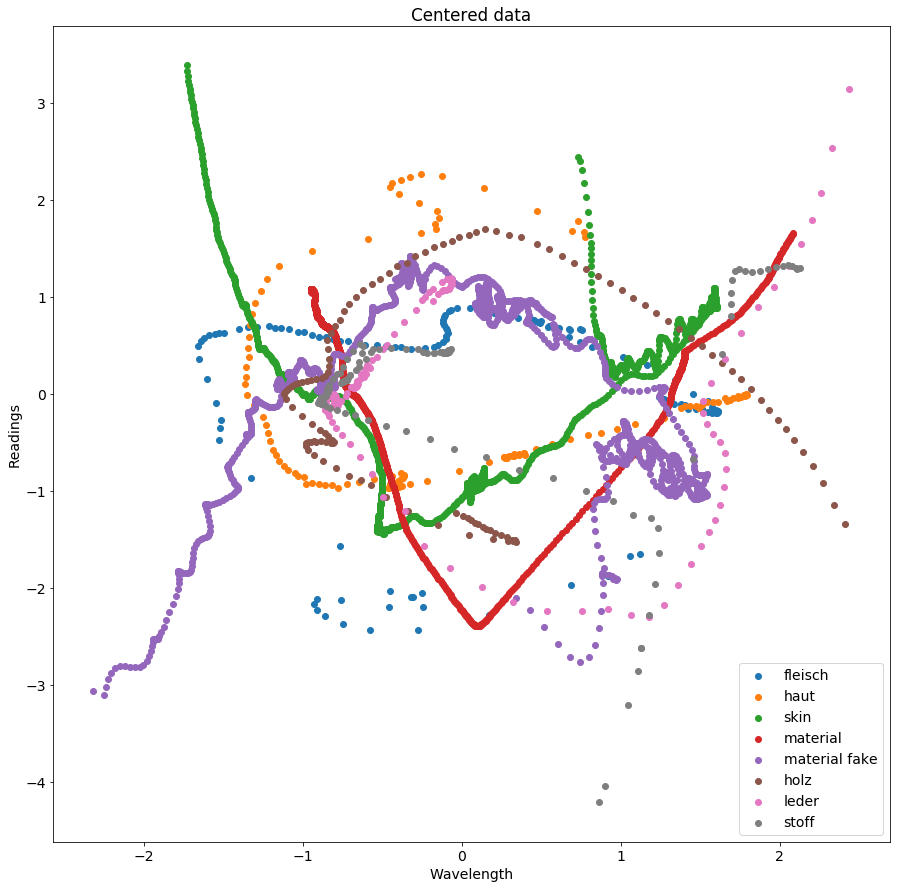

In [8]:
print('=========================================================================')
print("Performing PCA on the dataset to use the features with more relevance")
print('=========================================================================')
n = 2
print('------------- FLEISCH -------------')
fleisch_cleaned = dataCleanup(fleisch.drop(columns="nm"),n)
print('', fleisch_cleaned.shape)
print('-------------   HAUT  -------------')
haut_cleaned = dataCleanup(haut.drop(columns="nm"),n)
print('', haut_cleaned.shape)
print('-------------   SKIN  -------------')
skin_cleaned = dataCleanup(skin.drop(columns="nm"),n)
print('', skin_cleaned.shape)
print('-----------   MATERIAL  -----------')
material_cleaned = dataCleanup(material.drop(columns="nm"),n)
print('', material_cleaned.shape)
print('---------   MATERIAL FAKE  --------')
material_fake_cleaned = dataCleanup(material_fake.drop(columns="nm"),n)
print('', material_fake_cleaned.shape)
print('-------------   HOLZ  -------------')
holz_cleaned = dataCleanup(holz.drop(columns="nm"),n)
print('', holz_cleaned.shape)
print('-------------  LEDER  -------------')
leder_cleaned = dataCleanup(leder.drop(columns="nm"),n)
print('', leder_cleaned.shape)
print('-------------  STOFF  -------------')
stoff_cleaned = dataCleanup(stoff.drop(columns="nm"),n)
print('', stoff_cleaned.shape)

print('=========================================================================')
print("Plot centered data")
print('=========================================================================')


plt.figure(figsize=(15,15))

plt.scatter(fleisch_cleaned[:,0], fleisch_cleaned[:,1])
plt.scatter(haut_cleaned[:,0], haut_cleaned[:,1])
plt.scatter(skin_cleaned[:,0], skin_cleaned[:,1])
plt.scatter(material_cleaned[:,0], material_cleaned[:,1])
plt.scatter(material_fake_cleaned[:,0], material_fake_cleaned[:,1])
plt.scatter(holz_cleaned[:,0], holz_cleaned[:,1])
plt.scatter(leder_cleaned[:,0], leder_cleaned[:,1])
plt.scatter(stoff_cleaned[:,0], stoff_cleaned[:,1])
plt.grid()
plt.legend(['fleisch','haut','skin','material','material fake','holz',\
           'leder', 'stoff'])
plt.xlabel('Wavelength')
plt.ylabel('Readings')
plt.title('Centered data')
plt.show()

## Implementing MLP for the cleaned data

#### Build the confusion matrix to validate the output

In [22]:
def plot_conf(cm):    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    classNames = ['Negative','Positive']
    plt.title('Living vs Non - living')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

### Implementing kfold

In [14]:
Sequential.compile?

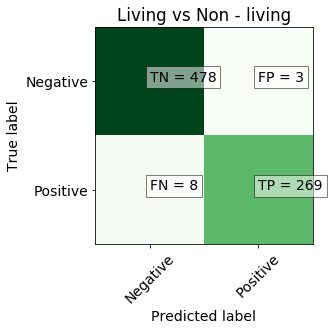

 Recall:  0.9711191335740073


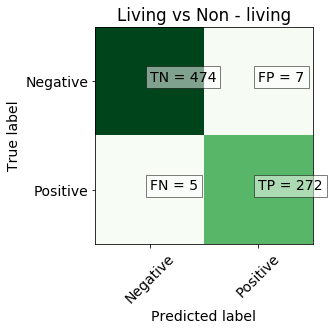

 Recall:  0.9819494584837545


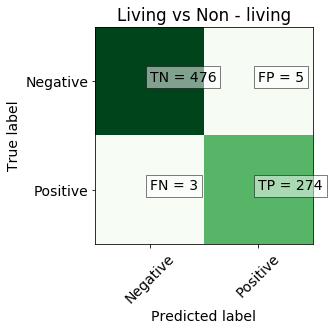

 Recall:  0.9891696750902527


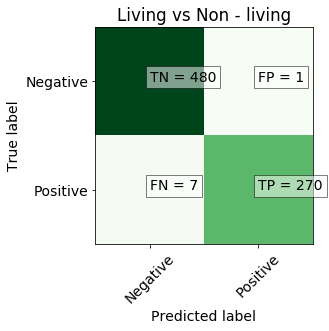

 Recall:  0.9747292418772563


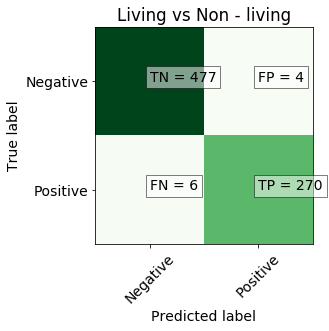

 Recall:  0.9782608695652174
 Average accuracy 0.99% (+/- 0.00%)
 Average precision 0.99% (+/- 0.01%)
 Average recall 0.98% (+/- 0.01%)
 Average f1 0.98% (+/- 0.00%)
 Average recall based on Conf Matrix 0.98% (+/- 0.01%)


In [26]:
#define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
accuracy_scores = []
recall_scores = []
precision_scores = []
f1_scores = []
recall_cm_scores = []
data_array = np.array(df_shuffled)
X = data_array[:, :-1]
Y = data_array[:, -1]

for train, test in kfold.split(X, Y):
    model = Sequential()
    model.add(Dense(12, input_dim=5, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',\
                        keras_metrics.precision(),keras_metrics.recall(),\
                        keras_metrics.f1_score()])
#     model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy',\
#                         keras_metrics.precision(),keras_metrics.recall(),\
#                         keras_metrics.f1_score()])
    model.fit(X[train], Y[train], epochs = 100, batch_size = 50, \
              validation_data = (X[test], Y[test]), verbose=0)
    print('======================================================')
    y_pred = model.predict_classes(X[test])
    scores = model.evaluate(X[test], Y[test], verbose=0)
    conf_matrix = confusion_matrix(Y[test], y_pred)
    
    recall_cm = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
#     print(' confusion matrix is')
#     print('', conf_matrix)
    plot_conf(conf_matrix)
    print(' Recall: ', recall_cm)
    print('======================================================')
    accuracy_scores.append(scores[1])
    precision_scores.append(scores[2])
    recall_scores.append(scores[3])
    f1_scores.append(scores[4])
    recall_cm_scores.append(recall_cm)
    
print(" Average accuracy %.2f%% (+/- %.2f%%)" % \
      (np.mean(accuracy_scores), np.std(accuracy_scores)))
print(" Average precision %.2f%% (+/- %.2f%%)" % \
      (np.mean(precision_scores), np.std(precision_scores)))
print(" Average recall %.2f%% (+/- %.2f%%)" % \
      (np.mean(recall_scores), np.std(recall_scores)))
print(" Average f1 %.2f%% (+/- %.2f%%)" % \
      (np.mean(f1_scores), np.std(f1_scores)))
print(" Average recall based on Conf Matrix %.2f%% (+/- %.2f%%)" % \
      (np.mean(recall_cm_scores), np.std(recall_scores)))    

In [28]:

X_train, X_test, y_train, y_test = train_test_split(ultimate_dataset, ultimate_labels, test_size = 0.20)  


In [7]:
X_train.shape

(3031, 5)

In [8]:


def svm_evaluator(X, y, cs, gm = None):
    print('===================================')
    print(' C:', cs)
    print('-----------------------------------')
    svclassifier.fit(X_train, y_train) 
    y_pred = svclassifier.predict(X_test) 
#     print('',confusion_matrix(y_test,y_pred)) 
    plot_conf(confusion_matrix(y_test,y_pred))
    print('',classification_report(y_test,y_pred)) 
    print('===================================')
    
    
    

 SVM loaded
 SVM trained
 SVM tested


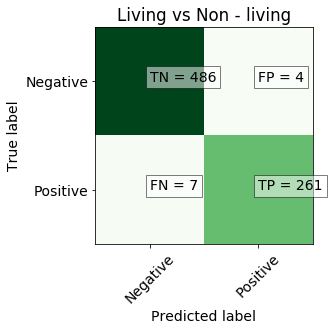

              precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       490
        1.0       0.98      0.97      0.98       268

avg / total       0.99      0.99      0.99       758



In [31]:

# c = [0.001, 0.01, 0.1, 1, 10]
# g = [0.001, 0.01, 0.1, 1]

# for cs in c:
#     svclassifier = SVC(kernel= 'linear',C = cs)  
#     svm_evaluator(X_train, y_train, cs)
svclassifier = SVC(kernel= 'rbf',gamma=0.3, C=2.0) 
print(' SVM loaded')
svclassifier.fit(X_train, y_train) 
print(' SVM trained')
y_pred = svclassifier.predict(X_test) 
print(' SVM tested')
plot_conf(confusion_matrix(y_test,y_pred))
print('',classification_report(y_test,y_pred)) 
# svm_evaluator(X_train, y_train, 1.0)

 SVM loaded
 SVM trained
 SVM tested


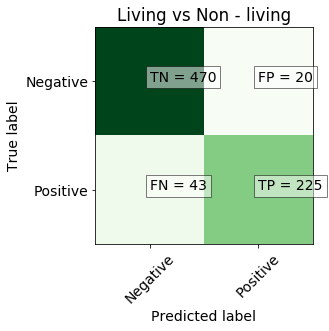

              precision    recall  f1-score   support

        0.0       0.92      0.96      0.94       490
        1.0       0.92      0.84      0.88       268

avg / total       0.92      0.92      0.92       758



In [44]:
# svclassifier = SVC(kernel='poly', degree=3, gamma=0.7, C=2.0) 
svclassifier = SVC(kernel='poly', degree=3, gamma=0.7, C=2.0) 
print(' SVM loaded')
svclassifier.fit(X_train, y_train) 
print(' SVM trained')
y_pred = svclassifier.predict(X_test) 
print(' SVM tested')
plot_conf(confusion_matrix(y_test,y_pred))
print('',classification_report(y_test,y_pred)) 